# Loading Data

In [1]:
import torch
eeg_55_95_data = torch.load("eeg_55_95_std.pth")
eeg_55_95_eeg = eeg_55_95_data.get("dataset")
eeg_55_95_labels = eeg_55_95_data.get("labels")
eeg_55_95_images = eeg_55_95_data.get("images")

# the data has 40 image classes and 50 images per class,
# so the expected number of images is 2000
# there are 6 subjects, so 12000 EEG time series are expected
# however, due to some issues with the data, there are only 11965 EEG time series

# eeg data is an array of 11965 dictionaries
# each dictionary has 3 keys: "eeg", "image", "label", "subject"
# eeg is a 128 x ~500 tensor corresponding to EEG data at 128 channels
# the images is an index of the image shown, corresponding to the images array
# the label is the label of the image shown, corresponding to the labels array
# the subject is the subject number of the person whose data this is

# the goal is to create a "eeg_data" tensor of size 11965 x 128 x 440, 
# where each EEG time series is trimmed to the last 440 time steps
# and another "eeg_labels" tensor of size 11965 x 40,
# where each row is a one-hot vector corresponding to the label of the image shown

In [7]:
# Initialize the tensors
eeg_data = torch.zeros((11965, 128, 440))
eeg_labels = torch.zeros((11965, 40))

# Process each EEG time series and label
for i, data in enumerate(eeg_55_95_eeg):
    # Trim the EEG time series to the last 440 time steps
    eeg_data[i] = data["eeg"][:, -440:]

    # Convert label to one-hot vector
    label_idx = data["label"]
    eeg_labels[i][label_idx] = 1

# eeg_data and eeg_labels are now ready to be used
eeg_data.shape, eeg_labels.shape

(torch.Size([11965, 128, 440]), torch.Size([11965, 40]))

In [3]:
# Split the eeg_data tensor into two halves along the time dimension
eeg_data_first_half = eeg_data[..., :220]  # First 220 time points
eeg_data_second_half = eeg_data[..., 220:]  # Second 220 time points

# Perform FFT on each half
fft_data_first_half = torch.fft.rfft(eeg_data_first_half, dim=2)
fft_data_second_half = torch.fft.rfft(eeg_data_second_half, dim=2)

# Take the absolute values
fft_data_first_half_abs = torch.abs(fft_data_first_half)
fft_data_second_half_abs = torch.abs(fft_data_second_half)

# Concatenate the FFT results from both halves
fft_data = torch.cat([fft_data_first_half_abs, fft_data_second_half_abs], dim=2)

# Flatten the data as before
fft_flat_data = fft_data.flatten(start_dim=1)
eeg_flat_data = eeg_data.flatten(start_dim=1)

# Assuming eeg_labels is defined elsewhere in your code
# Output shapes for verification
eeg_flat_data.shape, fft_flat_data.shape, eeg_labels.shape

(torch.Size([11965, 56320]),
 torch.Size([11965, 28416]),
 torch.Size([11965, 40]))

In [4]:
from sklearn.model_selection import train_test_split

fft_train, fft_test, labels_train, labels_test = train_test_split(
    fft_flat_data, eeg_labels, test_size=0.1, random_state=42
)

fft_train.shape, fft_test.shape, labels_train.shape, labels_test.shape

(torch.Size([10768, 28416]),
 torch.Size([1197, 28416]),
 torch.Size([10768, 40]),
 torch.Size([1197, 40]))

# Siamese

In [5]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGTripletDataset(Dataset):
    def __init__(self, eegs, labels):
        self.eegs = eegs
        self.labels = labels

        self.labels_set = set(labels.numpy())
        self.label_to_indices = {label: np.where(labels.numpy() == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):
        eeg1, label1 = self.eegs[index], self.labels[index].item()

        # Positive example
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[label1])
        eeg2 = self.eegs[positive_index]

        # Negative example
        negative_label = np.random.choice(list(self.labels_set - {label1}))
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        eeg3 = self.eegs[negative_index]

        return eeg1, eeg2, eeg3

    def __len__(self):
        return len(self.eegs)

# Initialize the dataset
eegs_tensor = fft_train  # EEG data tensor
labels_tensor = labels_train.argmax(dim=1)  # Convert one-hot to integer labels

triplet_dataset = EEGTripletDataset(eegs_tensor, labels_tensor)

# DataLoader
batch_size = 32
triplet_dataloader = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.ReLU()
        )

    def forward(self, x):
        return x + self.block(x)  # Adding input x to the output of the block

class SIAVAE(nn.Module):
    def __init__(self, eeg_size, latent_dim):
        super(SIAVAE, self).__init__()
        self.latent_dim = latent_dim

        # EEG encoder
        self.eeg_encoder = nn.Sequential(
            nn.Linear(eeg_size, 256),
            nn.ReLU(),
            ResidualBlock(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            ResidualBlock(128),
            nn.Linear(128, latent_dim * 2)  # Outputting mean and log-variance
        )

        # Decoder with residual blocks
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            ResidualBlock(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            ResidualBlock(256),
            nn.Linear(256, eeg_size),
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, eeg):

        eeg_latent = self.eeg_encoder(eeg)

        # Split the result into mean and log-variance
        mu, log_var = torch.chunk(eeg_latent, 2, dim=1)

        z = self.reparameterize(mu, log_var)
        recon_image = self.decoder(z)
        return recon_image, z, mu, log_var

# Initialize the model
eeg_size = 128 * 222  # Adjust according to your EEG data shape
latent_dim = 10  # You can experiment with this
siavae = SIAVAE(eeg_size, latent_dim)

In [7]:
from tqdm import tqdm
import torch
import torch.nn as nn

# Assuming siamese_network is your Siamese Network model
# and triplet_loss is your contrastive loss function

optimizer = torch.optim.Adam(siavae.parameters(), lr=0.0005)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
siavae = siavae.to(device)
num_epochs = 100

triplet_loss = nn.TripletMarginLoss(reduction='mean')

recon_losses = []
kl_losses = []
siamese_losses = []

def siamese_loss_weight(epoch, start_epoch=50, end_epoch=100):
    if epoch < start_epoch:
        return 0.0
    elif epoch > end_epoch:
        return 1.0
    else:
        optimizer.lr = 0.0001
        return (epoch - start_epoch) / (end_epoch - start_epoch)

# Example training loop
for epoch in range(num_epochs):
    loop = tqdm(triplet_dataloader, leave=True)  # data_loader yields (eeg_triplet, image_triplet)
    # current_siamese_weight = 0.2

    total_recon_loss, total_kl_loss, total_siamese_loss = 0, 0, 0

    for anchor_eeg, positive_eeg, negative_eeg in loop:
        anchor_eeg, positive_eeg, negative_eeg = anchor_eeg.to(device), positive_eeg.to(device), negative_eeg.to(device)

        # Forward pass for VAE (reconstruction) and Siamese (embeddings)
        reconstructed_anchor, anchor_embedding, anchor_mu, anchor_log_var = siavae(anchor_eeg)
        reconstructed_positive, positive_embedding, positive_mu, positive_log_var = siavae(positive_eeg)
        reconstructed_negative, negative_embedding, negative_mu, negative_log_var = siavae(negative_eeg)

        # positive_embedding_detached = positive_embedding.detach()
        # negative_embedding_detached = negative_embedding.detach()

        # Compute VAE loss
        recon_loss = F.mse_loss(reconstructed_anchor, anchor_eeg, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + anchor_log_var - anchor_mu.pow(2) - anchor_log_var.exp())
        siamese_loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)

        loss = 0.0015 * recon_loss + 0.0003 * kl_loss + siamese_loss

        # Accumulate losses
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_siamese_loss += siamese_loss.item()

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(recon_loss=total_recon_loss, kl_loss=total_kl_loss, siamese_loss=total_siamese_loss)

    loop.close()

    num_batches = len(triplet_dataloader)
    recon_losses.append(total_recon_loss / num_batches)
    kl_losses.append(total_kl_loss / num_batches)
    siamese_losses.append(total_siamese_loss / num_batches)

Epoch [100/100]: 100%|██████████| 337/337 [00:18<00:00, 17.78it/s, kl_loss=1.27e+5, recon_loss=3.01e+4, siamese_loss=241] 


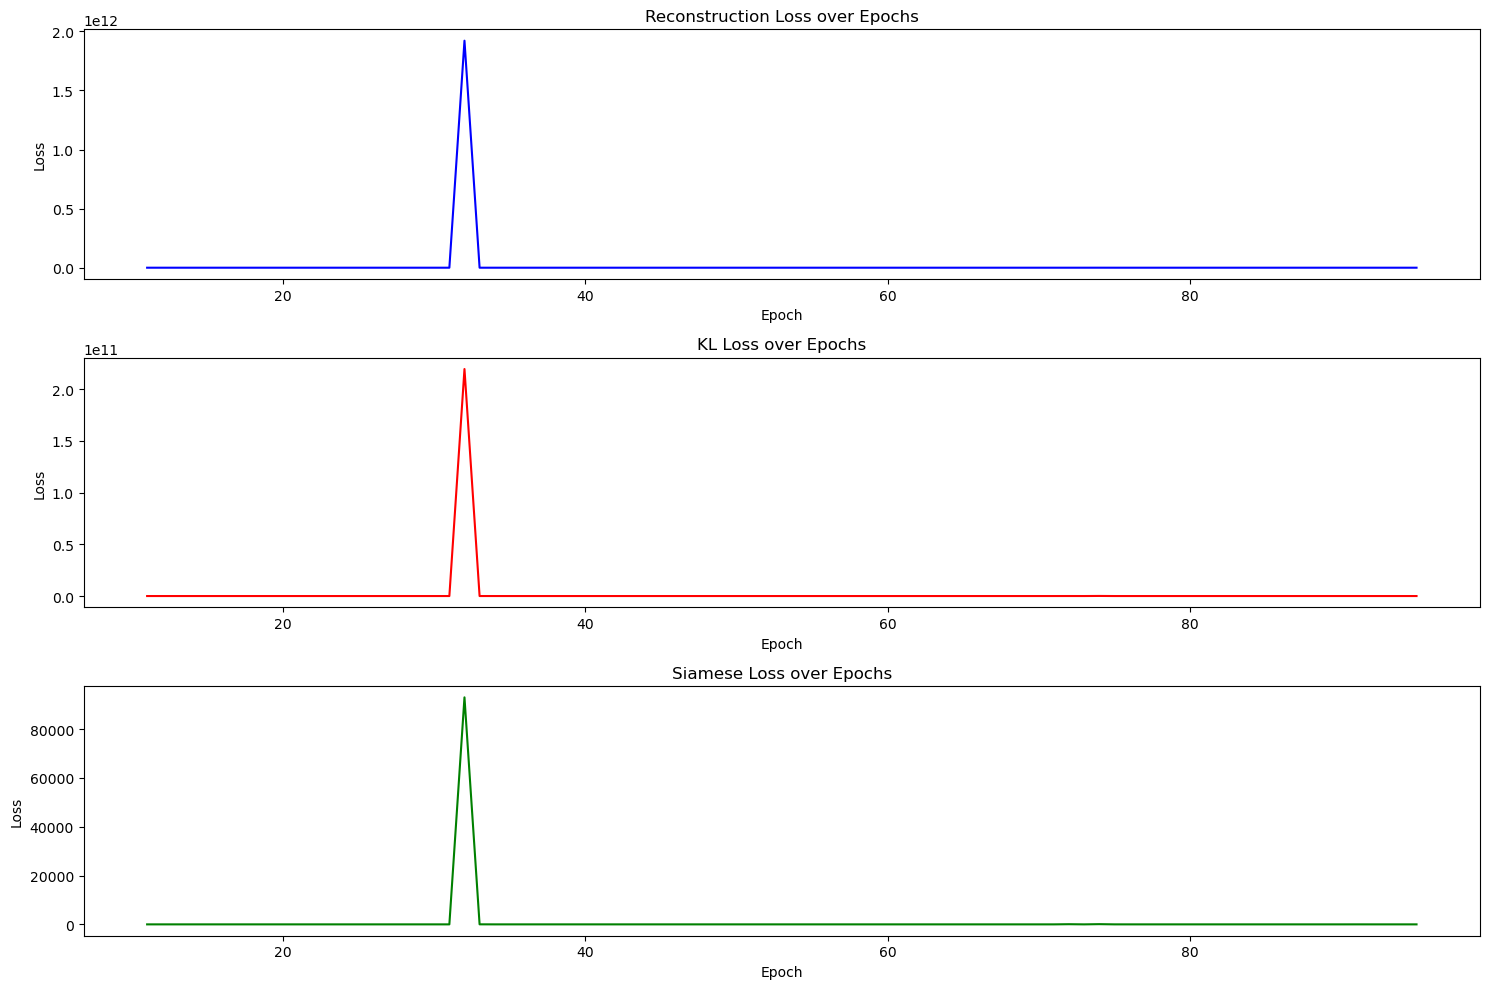

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generating random data for each loss type
epochs = np.arange(11, 96)

# Creating a figure with 3 subplots
plt.figure(figsize=(15, 10))

# Plot for Reconstruction Loss
plt.subplot(3, 1, 1)
sns.lineplot(x=epochs, y=recon_losses[10:95], color='blue')
plt.title('Reconstruction Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot for KL Loss
plt.subplot(3, 1, 2)
sns.lineplot(x=epochs, y=kl_losses[10:95], color='red')
plt.title('KL Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot for Siamese Loss
plt.subplot(3, 1, 3)
sns.lineplot(x=epochs, y=siamese_losses[10:95], color='green')
plt.title('Siamese Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()

plt.savefig('losses_curve.pdf', format='pdf')
plt.show()

# Classifier on Latents

In [9]:
model = siavae.to(device)

In [10]:
recon_image, z, mu, log_var = model(fft_train.to(device))

classifier_inputs_tensor = z.detach()
classifier_outputs_tensor = labels_train.detach()

classifier_inputs_np = classifier_inputs_tensor.cpu().numpy()
classifier_outputs_np = classifier_outputs_tensor.cpu().numpy()

print(classifier_inputs_np.shape)
print(classifier_outputs_np.shape)

(10768, 10)
(10768, 40)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiClassClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size // 4, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# Assuming your latent vector size and number of classes
input_size = 10
hidden_size = 128
num_classes = 40
classifier_model = MultiClassClassifier(input_size, hidden_size, num_classes)

In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset

cvae_class_dataset = TensorDataset(classifier_inputs_tensor, classifier_outputs_tensor)

cvae_class_data_loader = DataLoader(cvae_class_dataset, batch_size=32, shuffle=True)

In [13]:
import torch.optim as optim
from tqdm import tqdm

# Initialize the model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)


num_epochs = 200
epoch_losses = []

for epoch in range(num_epochs):
    # Wrap your data loader with tqdm for a progress bar
    loop = tqdm(cvae_class_data_loader, leave=True)

    for inputs, targets in loop:
        # Forward pass
        outputs = classifier_model(inputs.to('cpu'))
        loss = criterion(outputs, targets.argmax(dim=1))  # Convert one-hot to class indices

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

        # Update the progress bar
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())

    # Close the tqdm loop after the epoch ends
    loop.close()

Epoch [324/2000]:   0%|          | 1/337 [00:00<00:10, 33.47it/s, loss=2.52]


KeyboardInterrupt: 

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np

test_dataset = TensorDataset(fft_test, labels_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

def test_model(latent_model, classifier_model, test_loader):
    latent_model.eval()
    classifier_model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            _, _, latents, _ = latent_model(inputs.to('cpu'))
            outputs = classifier_model(latents.to('cpu'))
            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate accuracy
    predicted = np.argmax(all_outputs, axis=1)
    correct = np.sum(predicted == np.argmax(all_targets, axis=1))
    total = all_targets.shape[0]
    accuracy = 100.0 * correct / total
    print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

    # Calculate AUROC for each class
    counter = 0

    auroc_per_class = []
    for i in range(all_targets.shape[1]):
        try:
            score = roc_auc_score(all_targets[:, i], all_outputs[:, i])
            auroc_per_class.append(score)
        except ValueError:
            counter += 1
            pass  # This occurs if a class is not represented in the targets

    # Calculate average AUROC
    avg_auroc = np.mean(auroc_per_class)
    print(f'Number of classes not included in AUROC calculation: {counter}')
    print(f'Average AUROC: {avg_auroc:.2f}')

# Example Usage
# Assuming you have a DataLoader 'test_loader' for your test dataset
# and your models 'latent_model' and 'classifier_model'
test_model(model.cpu(), classifier_model, test_loader)

Accuracy of the model on the test dataset: 14.20%
Number of classes not included in AUROC calculation: 0
Average AUROC: 0.87


In [15]:
_, _, latents, _ = model(fft_test)
outputs = classifier_model(latents.to('cpu'))

prediction = np.argmax(outputs.detach().numpy(), axis=1)

print(prediction[0:50])

[12 27 28  7 23 17 24 25 33 27 17 16  7 38 28 11  6 27  4  8 35 26 10 33
 12 21 33  6 28 31 28 20 22  6  8  4 15 22 18 33 18 35 31  6 12 17 12 18
  3 28]


In [16]:
# torch.save(model.state_dict(), 'models/siavae_resid_96percent_auroc_34percent_accuracy.pth')
# torch.save(classifier_model.state_dict(), 'models/classifier_siavae_resid_96percent_auroc_34percent_accuracy.pth')

# Joint Training

In [17]:
# siavae.load_state_dict(torch.load('models/siavae_newdata_newfft_36percent_accuracy.pth'))
# classifier_model.load_state_dict(torch.load('models/classifier_siavae_newdata_newfft_36percent_accuracy.pth'))

In [18]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import random

class JointDataset(Dataset):
    def __init__(self, eegs, images, labels):
        self.eegs = eegs
        self.images = images
        self.labels = labels

        self.labels_set = set(labels.numpy())
        self.label_to_indices = {label: np.where(labels.numpy() == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):
        eeg1, img1, label1 = self.eegs[index], self.images[index], self.labels[index].item()

        # Positive example
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[label1])
        eeg2, img2 = self.eegs[positive_index], self.images[positive_index]

        # Negative example
        negative_label = np.random.choice(list(self.labels_set - {label1}))
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        eeg3, img3 = self.eegs[negative_index], self.images[negative_index]

        return (eeg1, eeg2, eeg3), (img1, img2, img3), (label1, label1, negative_label)

    def __len__(self):
        return len(self.eegs)

# Initialize the dataset
eegs_tensor = fft_train  # EEG data tensor
images_tensor = labels_train  # Images data tensor
labels_tensor = labels_train.argmax(dim=1)  # Convert one-hot to integer labels

joint_dataset = JointDataset(eegs_tensor, images_tensor, labels_tensor)

# DataLoader
batch_size = 32
joint_dataloader = DataLoader(joint_dataset, batch_size=batch_size, shuffle=True)

In [19]:
def combined_loss(recon_image, eeg, mu, log_var, class_logits, y, anchor_embedding, positive_embedding, negative_embedding):
    # VAE losses
    recon_loss = F.mse_loss(recon_image, eeg)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Triplet loss
    siamese_loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)

    # Classification loss
    classification_loss = F.cross_entropy(class_logits, y)

    # Combined loss
    loss = classification_loss  # Adjust weights as needed
    return loss, recon_loss, kl_loss, siamese_loss, classification_loss

In [46]:
optimizer = torch.optim.Adam(list(siavae.parameters()) + list(classifier_model.parameters()), lr=0.00005)

siavae = siavae.to(device)
classifier_model = classifier_model.to(device)

num_epochs = 5

classification_losses = []
recon_losses = []
kl_losses = []
siamese_losses = []

for epoch in range(num_epochs):
    # Wrap your data loader with tqdm for a progress bar
    loop = tqdm(joint_dataloader, leave=True)

    total_classification_loss, total_recon_loss, total_kl_loss, total_siamese_loss = 0, 0, 0, 0

    for (anchor_eeg, positive_eeg, negative_eeg), (anchor_img, positive_img, negative_img), (y, _, _) in loop:

        # Forward pass
        reconstructed_anchor, anchor_embedding, anchor_mu, anchor_log_var = siavae(anchor_eeg)
        reconstructed_positive, positive_embedding, positive_mu, positive_log_var = siavae(positive_eeg)
        reconstructed_negative, negative_embedding, negative_mu, negative_log_var = siavae(negative_eeg)
        class_logits = classifier_model(anchor_embedding)

        positive_embedding_detached = positive_embedding.detach()
        negative_embedding_detached = negative_embedding.detach()

        # Compute losses
        loss, recon_loss, kl_loss, siamese_loss, classification_loss = combined_loss(reconstructed_anchor, anchor_eeg, anchor_mu, anchor_log_var, class_logits, y, anchor_embedding, positive_embedding, negative_embedding)

        total_classification_loss += classification_loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_siamese_loss += siamese_loss.item()

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item(), recon_loss=recon_loss.item(), kl_loss=kl_loss.item(), siamese_loss=siamese_loss.item(), classification_loss=classification_loss.item())

    # Close the tqdm loop after the epoch ends
    loop.close()

    num_batches = len(joint_dataloader)
    classification_losses.append(total_classification_loss / num_batches)
    recon_losses.append(total_recon_loss / num_batches)
    kl_losses.append(total_kl_loss / num_batches)
    siamese_losses.append(total_siamese_loss / num_batches)

Epoch [5/5]: 100%|██████████| 337/337 [00:10<00:00, 33.02it/s, classification_loss=0.0167, kl_loss=6.53e+4, loss=0.0167, recon_loss=4.08e+3, siamese_loss=11.3]   


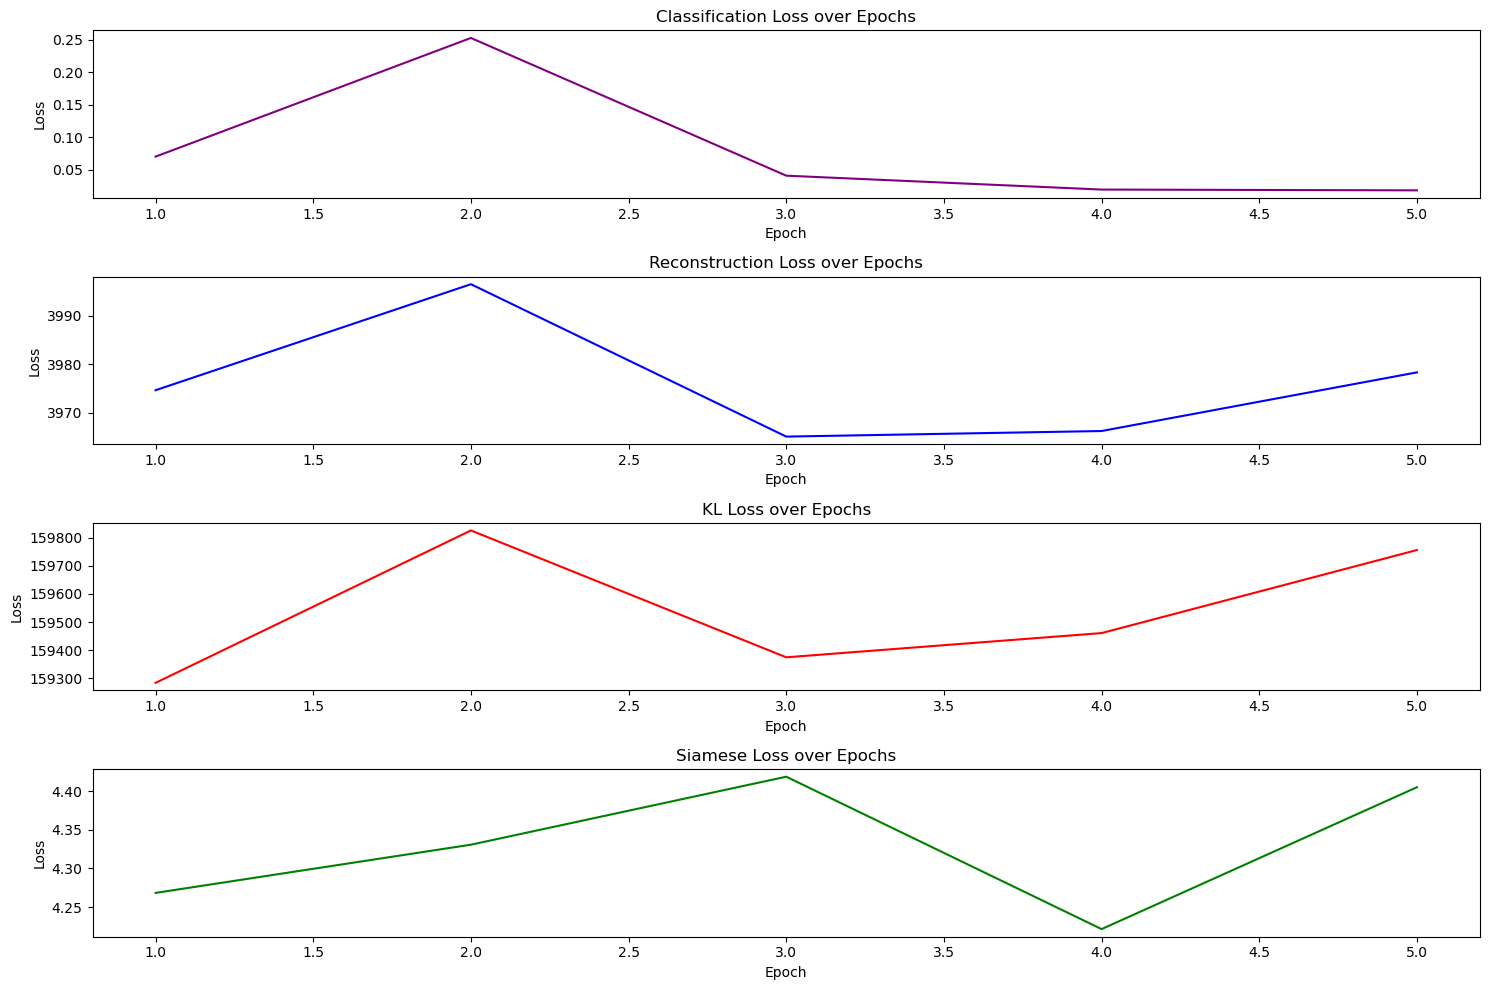

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generating random data for each loss type
epochs = np.arange(1, num_epochs + 1)

# Creating a figure with 3 subplots
plt.figure(figsize=(15, 10))

# Plot for Classification Loss
plt.subplot(4, 1, 1)
sns.lineplot(x=epochs, y=classification_losses, color='purple')
plt.title('Classification Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot for Reconstruction Loss
plt.subplot(4, 1, 2)
sns.lineplot(x=epochs, y=recon_losses, color='blue')
plt.title('Reconstruction Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot for KL Loss
plt.subplot(4, 1, 3)
sns.lineplot(x=epochs, y=kl_losses, color='red')
plt.title('KL Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot for Siamese Loss
plt.subplot(4, 1, 4)
sns.lineplot(x=epochs, y=siamese_losses, color='green')
plt.title('Siamese Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()

plt.show()

In [48]:
model = siavae.to(device)

def test_model(latent_model, classifier_model, test_loader):
    latent_model.eval()
    classifier_model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            _, _, latents, _ = latent_model(inputs.to('cpu'))
            outputs = classifier_model(latents.to('cpu'))
            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate accuracy
    predicted = np.argmax(all_outputs, axis=1)
    correct = np.sum(predicted == np.argmax(all_targets, axis=1))
    total = all_targets.shape[0]
    accuracy = 100.0 * correct / total
    print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

    # Calculate AUROC for each class
    counter = 0

    auroc_per_class = []
    for i in range(all_targets.shape[1]):
        try:
            score = roc_auc_score(all_targets[:, i], all_outputs[:, i])
            auroc_per_class.append(score)
        except ValueError:
            counter += 1
            pass  # This occurs if a class is not represented in the targets

    # Calculate average AUROC
    avg_auroc = np.mean(auroc_per_class)
    print(f'Number of classes not included in AUROC calculation: {counter}')
    print(f'Average AUROC: {avg_auroc:.2f}')

# Example Usage
# Assuming you have a DataLoader 'test_loader' for your test dataset
# and your models 'latent_model' and 'classifier_model'
test_model(model.cpu(), classifier_model, test_loader)

Accuracy of the model on the test dataset: 41.10%
Number of classes not included in AUROC calculation: 0
Average AUROC: 0.92


In [49]:
# torch.save(model.state_dict(), 'models/siavae_newdata_newfft_41percent_accuracy.pth')
# torch.save(classifier_model.state_dict(), 'models/classifier_siavae_newdata_newfft_41percent_accuracy.pth')

# Visualize

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from mne import create_info, EvokedArray
from mne.viz import plot_topomap

eeg_time_series = eeg_data[0]

# Create an info object and initial EvokedArray object
channel_names = ['O1', 'Oz', 'O2', 'PO7', 'PO3', 'POz', 'PO4', 'PO8',
                 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8']
info = create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
info.set_montage('standard_1020')
evoked_initial = EvokedArray(eeg_time_series[:, 0:1], info)

# Define a mask for occipital and parietal regions
mask = np.ones((len(channel_names),), dtype=bool)

# Define the animation update function with mask applied
def animate(i, evoked, data, mask):
    evoked.data = data[:, i:i+1]
    ax.clear()
    plot_topomap(evoked.data[:, 0], evoked.info, axes=ax, cmap='Spectral', show=False, mask=mask)
    ax.set_title(f'Time Point {i+1}', fontsize=10)

# Create the animation
fig, ax = plt.subplots()
ani = animation.FuncAnimation(fig, animate, frames=eeg_time_series.shape[1], fargs=(evoked_initial, eeg_time_series, mask), interval=200)
plt.close()

# Save the animation as a GIF
ani.save('eeg_128_animation.gif', writer=PillowWriter(fps=20))

# Display the GIF in Colab
from IPython.display import Image
Image(open('eeg_128_animation.gif','rb').read())

ValueError: Info (17) and data (128) must have same number of channels.

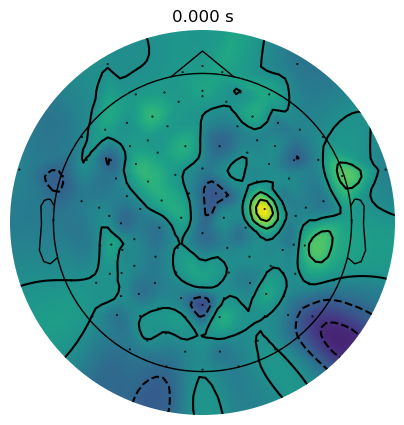

In [19]:
import numpy as np
import mne

# Generating random EEG data for 128 channels
data = eeg_data[0, :, 0]

# Creating a montage for 128 electrodes
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')

# Creating an Info object including the montage
info = mne.create_info(montage.ch_names, sfreq=1000, ch_types='eeg')
info.set_montage(montage)

# Creating the Evoked object with random data
evoked = mne.EvokedArray(data[:, np.newaxis], info, tmin=0)

fig, ax = plt.subplots(figsize=(5, 5))
evoked.plot_topomap(times=[0], ch_type='eeg', time_unit='s', cmap='viridis', scalings=1,
                    colorbar=False, size=6, axes=ax, show=False)

# Show the plot
plt.show()

In [25]:
# The execution state has been reset, so we need to redefine the setup and generate the animation again.
# This time, we will save it as a GIF file.

import numpy as np
import mne
from matplotlib import pyplot as plt
from matplotlib import animation

# Set random seed for reproducibility
np.random.seed(0)

n_channels = 128
n_times = 440  # 440 time points from 20ms to 460ms
sfreq = 1000  # Sampling frequency in Hz (1000 samples per second)
time = np.linspace(20, 460, n_times) / 1000  # Convert milliseconds to seconds
data = eeg_data[0, :, :]

# Create a montage for 128 electrodes
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')

# Create an Info object including the montage
info = mne.create_info(ch_names=montage.ch_names, sfreq=sfreq, ch_types='eeg')
info.set_montage(montage)

# Create the Evoked object with random data
evoked = mne.EvokedArray(data, info, tmin=0.02)  # tmin is the start time in seconds

# Initialize an animation figure
fig, ax = plt.subplots()

# Function to draw each frame of the animation
def animate(i):
    ax.clear()  # Clear the previous frame
    # Plot the topomap for the current time point
    evoked.plot_topomap(times=[time[i]], axes=ax, show=False, colorbar=False)

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=n_times, interval=50)

gif_path = "image_net_eeg_animation.gif"

# Create the animation again since the execution state was reset
anim = animation.FuncAnimation(fig, animate, frames=n_times, interval=50)

# Save the animation as a GIF file
anim.save(gif_path, writer='imagemagick', fps=20)

# Display the saved GIF
from IPython.display import Image
Image(filename=gif_path)


/opt/homebrew/anaconda3/envs/cs229/lib/python3.11/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


ValueError: Times should be between 0.02 and 0.459.